### Imports

In [1]:
from utils import *
import cv2
import numpy as np
import tf.keras.applications.VGG16 as VGG16
from tensorflow.keras import models, layers, optimizers, losses
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

### Read/Preprocess Data

In [2]:
X, y = read_images()
X = resize_and_rescale(X, rescale=False)
X_train, y_train, X_test, y_test = split_and_shuffle(X, y)

# convert to rgb images
X_train = np.array([[[[x,x,x]  for x in x2] for x2 in x1] for x1 in X_train])
X_test = np.array([[[[x,x,x]  for x in x2] for x2 in x1] for x1 in X_test])

### Model

In [3]:
def vgg16_model():
    vgg16 = VGG16(include_top=False, weights="imagenet", input_shape = (150,150, 3))

    # prevent training of VGG16
    vgg16.trainable = False

    model = models.Sequential()
    model.add(vgg16)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(4096, activation="relu"))
    model.add(layers.Dense(4096, activation="relu"))
    model.add(layers.Dense(2, activation="sigmoid"))
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [4]:
model = vgg16_model()
model.summary()

2022-04-30 17:30:21.760427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 17:30:21.804502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 17:30:21.804692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 17:30:21.806294: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 2)                 8194      
                                                        

### Cross Validation and Testing

In [5]:
def cross_validation(X, y, epochs=10):
    results = []
    
    # split into 4 folds and fit 4 times
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(X):
        model = vgg16_model()
        res = model.fit(X[train_index],y[train_index],validation_data=(X[test_index],y[test_index]),epochs=epochs)
        results.append(res)
    
    # obtain average results throughout the epochs
    history = dict()
    history["accuracy"] = []
    history["val_accuracy"] = []
    history["loss"] = []
    history["val_loss"] = []
    
    for i in range(epochs):
        history["accuracy"].append(sum([res.history['accuracy'][i] for res in results])/len(results))
        history["val_accuracy"].append(sum([res.history['val_accuracy'][i] for res in results])/len(results))
        history["loss"].append(sum([res.history['loss'][i] for res in results])/len(results))
        history["val_loss"].append(sum([res.history['val_loss'][i] for res in results])/len(results))

    return history

In [6]:
history = cross_validation(X_train, y_train)

Epoch 1/10


2022-04-30 17:30:24.346400: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-30 17:30:24.778291: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-30 17:30:25.255250: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-30 17:30:25.937805: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-30 17:30:26.438911: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.3

4/5 [=======================>......] - ETA: 0s - loss: 41.6942 - accuracy: 0.5703

2022-04-30 17:30:28.643060: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.75GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-30 17:30:29.247035: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


5/5 [==============================] - ETA: 0s - loss: 37.0666 - accuracy: 0.5166

2022-04-30 17:30:31.416495: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-30 17:30:31.902865: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


5/5 [==============================] - 10s 1s/step - loss: 37.0666 - accuracy: 0.5166 - val_loss: 5.3438 - val_accuracy: 0.4510
Epoch 2/10
5/5 [==============================] - 2s 420ms/step - loss: 3.0876 - accuracy: 0.5762 - val_loss: 1.8168 - val_accuracy: 0.6471
Epoch 3/10
5/5 [==============================] - 2s 419ms/step - loss: 1.1180 - accuracy: 0.7947 - val_loss: 0.3636 - val_accuracy: 0.8824
Epoch 4/10
5/5 [==============================] - 2s 434ms/step - loss: 0.7966 - accuracy: 0.7881 - val_loss: 0.4124 - val_accuracy: 0.8235
Epoch 5/10
5/5 [==============================] - 2s 420ms/step - loss: 0.3441 - accuracy: 0.8543 - val_loss: 0.3660 - val_accuracy: 0.7843
Epoch 6/10
5/5 [==============================] - 2s 419ms/step - loss: 0.2579 - accuracy: 0.8874 - val_loss: 0.4113 - val_accuracy: 0.8039
Epoch 7/10
5/5 [==============================] - 2s 420ms/step - loss: 0.1711 - accuracy: 0.9470 - val_loss: 0.3424 - val_accuracy: 0.8431
Epoch 8/10
5/5 [================

2022-04-30 17:31:14.870400: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-30 17:31:15.421844: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-30 17:31:15.838639: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


5/5 [==============================] - 6s 1s/step - loss: 43.2785 - accuracy: 0.5526 - val_loss: 9.9814 - val_accuracy: 0.5400
Epoch 2/10
5/5 [==============================] - 2s 420ms/step - loss: 5.4952 - accuracy: 0.6645 - val_loss: 0.5791 - val_accuracy: 0.7800
Epoch 3/10
5/5 [==============================] - 2s 419ms/step - loss: 0.5525 - accuracy: 0.7829 - val_loss: 0.9668 - val_accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 2s 418ms/step - loss: 0.3927 - accuracy: 0.8224 - val_loss: 0.5632 - val_accuracy: 0.7600
Epoch 5/10
5/5 [==============================] - 2s 420ms/step - loss: 0.2049 - accuracy: 0.9211 - val_loss: 0.8519 - val_accuracy: 0.7200
Epoch 6/10
5/5 [==============================] - 2s 420ms/step - loss: 0.2009 - accuracy: 0.9145 - val_loss: 0.4923 - val_accuracy: 0.7600
Epoch 7/10
5/5 [==============================] - 2s 418ms/step - loss: 0.2157 - accuracy: 0.9342 - val_loss: 0.7128 - val_accuracy: 0.7600
Epoch 8/10
5/5 [=================

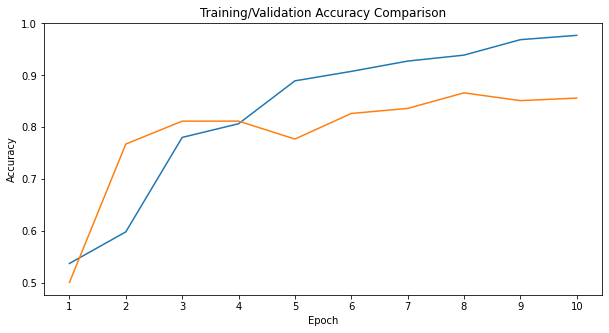

In [7]:
plot_accuracy_comparison(history["accuracy"], history["val_accuracy"])

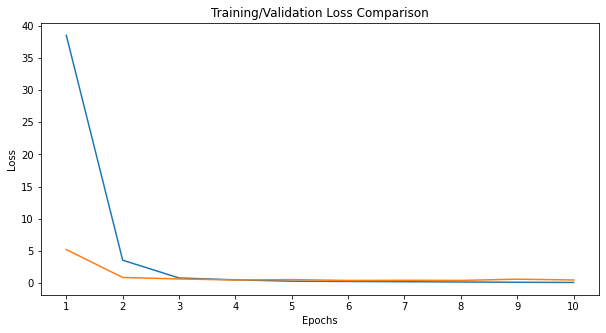

In [8]:
plot_loss_comparison(history["loss"], history["val_loss"])

In [9]:
history = model.fit(X_train, y_train, epochs=10)
loss, acc = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

Epoch 1/10
7/7 [==============================] - 4s 457ms/step - loss: 25.5059 - accuracy: 0.5990
Epoch 2/10
7/7 [==============================] - 2s 267ms/step - loss: 3.9647 - accuracy: 0.7921
Epoch 3/10
7/7 [==============================] - 2s 268ms/step - loss: 1.4374 - accuracy: 0.8020
Epoch 4/10
7/7 [==============================] - 2s 267ms/step - loss: 0.8165 - accuracy: 0.8168
Epoch 5/10
7/7 [==============================] - 2s 267ms/step - loss: 0.3257 - accuracy: 0.8911
Epoch 6/10
7/7 [==============================] - 2s 268ms/step - loss: 0.1908 - accuracy: 0.9158
Epoch 7/10
7/7 [==============================] - 2s 282ms/step - loss: 0.1226 - accuracy: 0.9356
Epoch 8/10
7/7 [==============================] - 2s 268ms/step - loss: 0.1429 - accuracy: 0.9257
Epoch 9/10
7/7 [==============================] - 2s 267ms/step - loss: 0.1068 - accuracy: 0.9554
Epoch 10/10
2/2 [==============================] - 1s 241ms/step - loss: 0.4753 - accuracy: 0.8627
Test Loss: 0.47532

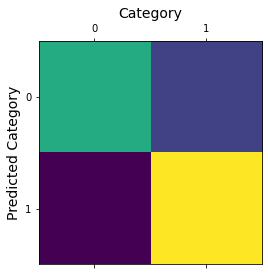

              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.96      0.82      0.89        33

    accuracy                           0.86        51
   macro avg       0.85      0.88      0.86        51
weighted avg       0.88      0.86      0.87        51



In [10]:
# show confusion matrix
y_pred=np.argmax(model.predict(X_test), axis=-1)
plot_confusion_matrix(y_test, y_pred)

# show other metrics
print(classification_report(y_pred,y_test))